# Class 8 - 11.5.20

# `pandas`, Visualization, `xarray` and Modeling

## String DataFrames

The raw data we have can sometimes come in the form of strings. Pandas support string DataFrames and allows for manipulation of these objects.

Note: I'm currently not discussing "bioinformatic sequences" of `ATGC` - these have a special `Seq` class in the Biopython package, the workhorse of Python bioinformatics.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

df_str = pd.DataFrame(['a', 'b', 'c', 'D  ', 'EFG', 'hij', 'k', '', ' LMNOP', 'QRST', 'UV', ' wxy', 'z'],
                      columns=['alpha'])
df_str

alpha
0        a
1        b
2        c
3      D  
4      EFG
5      hij
6        k
7         
8    LMNOP
9     QRST
10      UV
11     wxy
12       z

To access the varienty of string methods in pandas, use the `.str` attribute of a Series.

In [2]:
df_str.alpha.str.lower()

0          a
1          b
2          c
3        d  
4        efg
5        hij
6          k
7           
8      lmnop
9       qrst
10        uv
11       wxy
12         z
Name: alpha, dtype: object

In [3]:
df_str.alpha.str.strip()  # remove whitespaces

0         a
1         b
2         c
3         D
4       EFG
5       hij
6         k
7          
8     LMNOP
9      QRST
10       UV
11      wxy
12        z
Name: alpha, dtype: object

When parsing `.csv` data, the column names can sometimes be unorderly, having whitespaces and different capitalization conventions. Here's an example of how to make them look alike:

In [4]:
# Assume we parsed this DataFrame from some third-party source
csv_df = pd.DataFrame([], columns=[' Name', 'Age ', ' Gender ', 'Is single', 'Has children', 'Num of Children'])
csv_df

Empty DataFrame
Columns: [ Name, Age ,  Gender , Is single, Has children, Num of Children]
Index: []

Due to the fact that a column of a DataFrame is a regular Index object, we can use our string methods to make it look better:

In [5]:
csv_df.columns = csv_df.columns.str.strip()\
                               .str.lower()\
                               .str.replace(' ', '_')
csv_df  # stripped of leading and trailing whitespaces, 
        # removed capital letters
        # and replaced spaces with underscores

Empty DataFrame
Columns: [name, age, gender, is_single, has_children, num_of_children]
Index: []

We can get the first letter in each entry:

In [6]:
df_str.alpha.str.get(0)

0       a
1       b
2       c
3       D
4       E
5       h
6       k
7     NaN
8        
9       Q
10      U
11       
12      z
Name: alpha, dtype: object

You can also use regular expressions to extract patterns from each row of the Series.

In the mean time, a summary of all the string-related methods in pandas can be found [here](http://pandas.pydata.org/pandas-docs/stable/text.html). They contain most of the Pythonic string-related operations.

Note: String operations aren't as fast as numerical computations since they're currently implemented mostly with Python in the backend, and not C.

## Pandas Concatenation

Similar to numpy arrays, Series and DataFrame objects can be concatenated as well. The indexes of the pandas objects is what usually makes this operation non-trivial.

While this discussion might not seem to you super important, it's actually more useful than you'd think. Thinking of our different sets of data in terms of a large database can sometimes be a good analogy.

A full tutorial on this manner can be found in the official pandas tutorial, right [here](https://pandas.pydata.org/pandas-docs/stable/merging.html).

In [7]:
ser1 = pd.Series(['a', 'b', 'c'], index=[1, 2, 3])
ser2 = pd.Series(['d', 'e', 'f'], index=[4, 5, 6])
pd.concat([ser1, ser2])  # row-wise (axis=0) by default

1    a
2    b
3    c
4    d
5    e
6    f
dtype: object

In [8]:
# This simple behavior can be achieved using the append method
ser1.append(ser2)

1    a
2    b
3    c
4    d
5    e
6    f
dtype: object

In [9]:
df1 = pd.DataFrame([['a', 'A'], ['b', 'B']], columns=['let', 'LET'], index=[0, 1])
df2 = pd.DataFrame([['c', 'C'], ['d', 'D']], columns=['let', 'LET'], index=[2, 3])
pd.concat([df1, df2])  # again, along the first axis

let LET
0   a   A
1   b   B
2   c   C
3   d   D

In [10]:
df1 = pd.DataFrame([['a', 'A'], ['b', 'B']], columns=['let1', 'LET1'], index=[0, 1])
df2 = pd.DataFrame([['c', 'C'], ['d', 'D']], columns=['let2', 'LET2'], index=[2, 3])
pd.concat([df1, df2])  # pandas can't make the column index compatible, so it resorts to columnar concat
# the same result is achieved by pd.concat([df1, df2], axis=1)

/home/hagai/miniconda3/envs/course/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


LET1 LET2 let1 let2
0    A  NaN    a  NaN
1    B  NaN    b  NaN
2  NaN    C  NaN    c
3  NaN    D  NaN    d

If we wish to keep the integrity of the indices, we can use the `verify_integrity` keyword:

In [11]:
df1 = pd.DataFrame([['a', 'A'], ['b', 'B']], columns=['let', 'LET'], index=[0, 1])
df2 = pd.DataFrame([['c', 'C'], ['d', 'D']], columns=['let', 'LET'], index=[0, 2])
pd.concat([df1, df2], verify_integrity=True)

ValueError: Indexes have overlapping values: Int64Index([0], dtype='int64')

If we don't care about the indices, we can just ignore them:

In [12]:
pd.concat([df1, df2], ignore_index=True)  # creates a new index

let LET
0   a   A
1   b   B
2   c   C
3   d   D

We can also create a new MultiIndex if it makes more sense:

In [13]:
pd.concat([df1, df2], keys=['df1', 'df2'])  # "remembers" the origin of the data, super useful!

let LET
df1 0   a   A
    1   b   B
df2 0   c   C
    2   d   D

A real world example of concatenation is when we wish to join two datasets taken at different times. For example, if we conducted in day 1 measurements at times 8:00, 10:00, 14:00 and 16:00, but during day 2 we were a bit dizzy, and conducted the measurements at 8:00, 10:00, 13:00 and 16:30. On top of that, we recorded another parameter that we forget to measure at day 1.

The default concatenation behavior of pandas keeps all the data. In database terms (SQL people rejoice!) it's called an "outer join":

In [14]:
# Prepare mock data
times_day1 = pd.to_datetime(['08:00', '10:00', '14:00', '16:00'], format='%H:%M')
times_day2 = pd.to_datetime(['08:00', '10:00', '13:00', '16:30'], format='%H:%M')

temp_day1 = [36.6, 36.7, 37.0, 36.8]
temp_day2 = [35.9, 36.1, 36.5, 36.2]

humid_day1 = [30., 31., 30.4, 30.4]
humid_day2 = [32.2, 34.2, 30.9, 32.6]

light_day2 = [200, 130, 240, 210]

data_day1 = pd.DataFrame({'temp': temp_day1, 'humid': humid_day1}, index=times_day1)
data_day2 = pd.DataFrame({'temp': temp_day2, 'humid': humid_day2,
                          'light': light_day2}, index=times_day2)
data_day1

temp  humid
1900-01-01 08:00:00  36.6   30.0
1900-01-01 10:00:00  36.7   31.0
1900-01-01 14:00:00  37.0   30.4
1900-01-01 16:00:00  36.8   30.4

In [15]:
data_day2

temp  humid  light
1900-01-01 08:00:00  35.9   32.2    200
1900-01-01 10:00:00  36.1   34.2    130
1900-01-01 13:00:00  36.5   30.9    240
1900-01-01 16:30:00  36.2   32.6    210

In [16]:
# Outer join
pd.concat([data_day1, data_day2], join='outer')  # outer join is the default behavior  

/home/hagai/miniconda3/envs/course/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


humid  light  temp
1900-01-01 08:00:00   30.0    NaN  36.6
1900-01-01 10:00:00   31.0    NaN  36.7
1900-01-01 14:00:00   30.4    NaN  37.0
1900-01-01 16:00:00   30.4    NaN  36.8
1900-01-01 08:00:00   32.2  200.0  35.9
1900-01-01 10:00:00   34.2  130.0  36.1
1900-01-01 13:00:00   30.9  240.0  36.5
1900-01-01 16:30:00   32.6  210.0  36.2

To take the intersection of the columns we have to use inner join. The intersection is all the columns that are common in all datasets.

In [17]:
# Inner join - the excess data column was dropped (index is still not unique)
pd.concat([data_day1, data_day2], join='inner')

temp  humid
1900-01-01 08:00:00  36.6   30.0
1900-01-01 10:00:00  36.7   31.0
1900-01-01 14:00:00  37.0   30.4
1900-01-01 16:00:00  36.8   30.4
1900-01-01 08:00:00  35.9   32.2
1900-01-01 10:00:00  36.1   34.2
1900-01-01 13:00:00  36.5   30.9
1900-01-01 16:30:00  36.2   32.6

One can also specify the exact columns that should be the result of the join operation using the `columns` keyword. All in all, this basic functionality is easy to understand and allows for high flexibility. If you wish to conduct a more sophisticated join operation, you should use `pd.merge()`, as we'll show below.

Finally, joining on the columns will require the indices to be unique:

In [18]:
pd.concat([data_day1, data_day2], join='inner', axis='columns')

temp  humid  temp  humid  light
1900-01-01 08:00:00  36.6   30.0  35.9   32.2    200
1900-01-01 10:00:00  36.7   31.0  36.1   34.2    130

This doesn't look so good. The columns are a mess and we're barely left with any data. The right operation for this job is a `pd.merge`.

Merging two DataFrames into one is done in the following manner:

In [19]:
times = pd.to_datetime(['08:00', '10:00', '14:00', '16:00'], format='%H:%M')

temp_day1 = [36.6, 36.7, 37.0, 36.8]
humid_day1 = [30., 31., 30.4, 30.4]

df_temp = pd.DataFrame({'temp': temp_day1}, index=times)
df_humid = pd.DataFrame({'humid': humid_day1}, index=times)

pd.merge(df_temp, df_humid, right_index=True, left_index=True)  # merge with indices

temp  humid
1900-01-01 08:00:00  36.6   30.0
1900-01-01 10:00:00  36.7   31.0
1900-01-01 14:00:00  37.0   30.4
1900-01-01 16:00:00  36.8   30.4

In [20]:
# Slightly different data example
temp_day1 = [36.6, 36.7, 37.0, 36.8]
humid_day1 = [30., 31., 30.4, 30.4]

temp_day2 = [37.1, 36.6, 36.6, 36.7]

df_day1 = pd.DataFrame({'temp': temp_day1, 'humid': humid_day1}, index=times)
df_day2 = pd.DataFrame({'temp': temp_day2}, index=times)

df_day1

temp  humid
1900-01-01 08:00:00  36.6   30.0
1900-01-01 10:00:00  36.7   31.0
1900-01-01 14:00:00  37.0   30.4
1900-01-01 16:00:00  36.8   30.4

In [21]:
# Merging (as a method, not a procedure)
df_day1.merge(df_day2, left_index=True, right_index=True)
# This merge "remembers" the origin of the data, the "suffixes" keyword allows us to determine the new suffix

temp_x  humid  temp_y
1900-01-01 08:00:00    36.6   30.0    37.1
1900-01-01 10:00:00    36.7   31.0    36.6
1900-01-01 14:00:00    37.0   30.4    36.6
1900-01-01 16:00:00    36.8   30.4    36.7

In [22]:
# One more example, more similar to traditional databases
mouse_id = [511, 512, 513, 514]
meas1 = [67, 66, 89, 92]
meas2 = [45, 45, 65, 61]

data1 = pd.DataFrame({'id': mouse_id, 'blood_vol': meas1})
data2 = pd.DataFrame({'id': mouse_id, 'monocytes': meas2})
data1

id  blood_vol
0  511         67
1  512         66
2  513         89
3  514         92

In [23]:
data1.merge(data2)  # merge identified that the only "key" connecting the two tables was the 'id' key

id  blood_vol  monocytes
0  511         67         45
1  512         66         45
2  513         89         65
3  514         92         61

Database-like operation is a very broad topic in pandas, and it's another great example of why should you keep your data in a DataFrame.

If you feel like this join and merge operation might help you, don't hesitate to consult the official documents on this topic, linked [here](https://pandas.pydata.org/pandas-docs/stable/merging.html) (again).

## GroupBy

Yet another SQL-like feature that pandas posses is the group-by operation, sometimes known as "split-apply-combine".

In [155]:
# Mock data
subject = [100, 101, 102, 106, 108, 109]
dead = [True, True, False, True, False, False]
took_med = [False, True, True, False, False, True]
val1 = np.random.random(6)
val2 = np.random.random(6)
df = pd.DataFrame({'dead': dead, 'took_med': took_med,
                   'val1': val1, 'val2': val2}, index=subject)
df

dead  took_med      val1      val2
100   True     False  0.714929  0.991508
101   True      True  0.745557  0.179663
102  False      True  0.500172  0.317350
106   True     False  0.480194  0.979991
108  False     False  0.563612  0.717701
109  False      True  0.678208  0.721736

The most sensible thing to do is to group by either the "dead" or the "took_med" column (or both). This is the "split" part.

In [25]:
grouped = df.groupby('dead')
grouped  # DataFrameGroupBy object - intermediate object ready to be evaluated

This intermediate object is an internal pandas representation which should allow it to run very fast computation the moment we want to actually _know_ something about these groups. Assuming we want the mean of `val1`, as long as we won't specifically write `grouped.mean()` pandas will do very little in terms of actual computation. It's called "lazy evaluation".

The intermediate object has some useful attributes:

In [26]:
grouped.groups

{False: Int64Index([102, 108, 109], dtype='int64'),
 True: Int64Index([100, 101, 106], dtype='int64')}

In [27]:
len(grouped)  # True and False

2

If we wish to run some actual processing, we have to use an aggregation function:

In [28]:
grouped.sum()

took_med      val1      val2
dead                               
False       2.0  1.832133  1.906366
True        1.0  2.031222  2.011703

In [29]:
grouped.mean()

took_med      val1      val2
dead                               
False  0.666667  0.610711  0.635455
True   0.333333  0.677074  0.670568

In [30]:
grouped.size()

dead
False    3
True     3
dtype: int64

If we just wish to see one of the groups, we can use `get_group()`:

In [31]:
grouped.get_group(True)

took_med      val1      val2
100     False  0.660184  0.483995
101      True  0.910925  0.584703
106     False  0.460112  0.943004

We can also call several functions at once using the `.agg` attribute:

In [32]:
grouped.agg([np.sum, np.var])

took_med                val1                val2          
           sum       var       sum       var       sum       var
dead                                                            
False      2.0  0.333333  1.832133  0.010858  1.906366  0.069760
True       1.0  0.333333  2.031222  0.051022  2.011703  0.058202

In [156]:
grouped2 = df.groupby(['dead', 'took_med'])
grouped2

In [157]:
grouped2.agg([np.sum, np.var])

val1                val2          
                     sum       var       sum       var
dead  took_med                                        
False False     0.563612       NaN  0.717701       NaN
      True      1.178380  0.015848  1.039086  0.081764
True  False     1.195123  0.027550  1.971498  0.000066
      True      0.745557       NaN  0.179663       NaN

GroupBy offers many more features, documented [online](http://pandas.pydata.org/pandas-docs/stable/groupby.html).

## Exercise

1. _Strings in pandas:_ 
    - Generate a 1000-length `pd.DataFrame` filled with 3-letter strings. Use the `string` module, and others, to generate it quickly.
    - Add a column indicating if the string in this row has a `z` in its 2nd character.
    - Add a third column swapping the case of the 3-letter string in these specific lines (`azI` to `AZi`). In the other lines it should remain uncapitalized.

2. _Concatenation:_
    - Create three DataFrames with random values and shapes of (10x2), (10x1), (15x3). Their index should be simple ordinal integers, and their column names should differ.
    - Concatenate these DFs over the second axis using `pd.concat`.
    - Concatenate these DFs over the second axis using `pd.merge`.

3. _GroupBy:_
    - Create a DataFrame with two columns, 10k entries in length. The first should be a "flag" column, having a value of either 0 or 1, randomly. The second should be A sine wave from 0 to 20$\pi$, length of 10k. This simulates measuring a parameter from two distinct groups.
    - GroupBy the DataFrame, creating a GroupBy object.
    - Plot and overlay the two traces (of the two flags).
    - Use the `.rolling()` method to create a rolling average window of length 5 and overlay the result.


## Exercise solutions below...

In [33]:
# 1
import string
import numpy as np
import pandas as pd

# Generate the array
letters = list(string.ascii_lowercase)
size = 1000
num_of_letters = 3 
chosen = np.random.choice(letters, size*num_of_letters)
chosen = chosen.reshape((size, num_of_letters))
df = pd.DataFrame(chosen, columns=['a', 'b', 'c'])
df['letters'] = df.a.str.cat(df.b.str.cat(df.c))

# Filter
char = 'z'
df['no_z'] = df['letters'].str.find(char) != 1
df['swap'] = df['letters'].where(df['no_z'], other=df['letters'].str.upper())
df.head(20)

a  b  c letters   no_z swap
0   o  u  c     ouc   True  ouc
1   z  g  l     zgl   True  zgl
2   h  f  a     hfa   True  hfa
3   i  s  h     ish   True  ish
4   n  l  s     nls   True  nls
5   s  q  z     sqz   True  sqz
6   n  r  h     nrh   True  nrh
7   y  p  w     ypw   True  ypw
8   w  l  w     wlw   True  wlw
9   b  q  e     bqe   True  bqe
10  e  w  u     ewu   True  ewu
11  k  n  t     knt   True  knt
12  d  s  b     dsb   True  dsb
13  w  u  c     wuc   True  wuc
14  i  f  i     ifi   True  ifi
15  r  s  e     rse   True  rse
16  e  s  z     esz   True  esz
17  i  m  z     imz   True  imz
18  y  k  i     yki   True  yki
19  r  z  l     rzl  False  RZL

In [141]:
# 2
dfa = pd.DataFrame(np.random.random((10, 2)), columns=['a', 'b'])
dfb = pd.DataFrame(np.random.random((10, 1)), columns=['c'])
dfc = pd.DataFrame(np.random.random((15, 3)), columns=['d', 'e', 'f'])

# Using concat
print(pd.concat([dfa, dfb, dfc], axis=1))
# Using merge
pd.merge(pd.merge(dfa, dfb, how='outer', left_index=True, right_index=True), 
         dfc, how='outer', left_index=True, right_index=True)

           a         b         c         d         e         f
0   0.421588  0.349573  0.880830  0.298144  0.097954  0.671765
1   0.588978  0.876096  0.847501  0.599685  0.116049  0.343751
2   0.080654  0.789295  0.581479  0.677196  0.791476  0.094970
3   0.254450  0.029239  0.757374  0.275480  0.842886  0.326542
4   0.563156  0.068659  0.489165  0.083579  0.361458  0.126509
5   0.815698  0.564067  0.784220  0.533468  0.506029  0.773341
6   0.609655  0.896839  0.048228  0.123713  0.929718  0.101638
7   0.496757  0.940252  0.439305  0.109096  0.761597  0.224191
8   0.459934  0.867104  0.272374  0.750058  0.146211  0.678183
9   0.417468  0.655386  0.686701  0.672522  0.030861  0.529002
10       NaN       NaN       NaN  0.759838  0.414612  0.073202
11       NaN       NaN       NaN  0.627386  0.312019  0.204642
12       NaN       NaN       NaN  0.372016  0.384388  0.520225
13       NaN       NaN       NaN  0.075525  0.986405  0.522759
14       NaN       NaN       NaN  0.029913  0.707034  0

a         b         c         d         e         f
0   0.421588  0.349573  0.880830  0.298144  0.097954  0.671765
1   0.588978  0.876096  0.847501  0.599685  0.116049  0.343751
2   0.080654  0.789295  0.581479  0.677196  0.791476  0.094970
3   0.254450  0.029239  0.757374  0.275480  0.842886  0.326542
4   0.563156  0.068659  0.489165  0.083579  0.361458  0.126509
5   0.815698  0.564067  0.784220  0.533468  0.506029  0.773341
6   0.609655  0.896839  0.048228  0.123713  0.929718  0.101638
7   0.496757  0.940252  0.439305  0.109096  0.761597  0.224191
8   0.459934  0.867104  0.272374  0.750058  0.146211  0.678183
9   0.417468  0.655386  0.686701  0.672522  0.030861  0.529002
10       NaN       NaN       NaN  0.759838  0.414612  0.073202
11       NaN       NaN       NaN  0.627386  0.312019  0.204642
12       NaN       NaN       NaN  0.372016  0.384388  0.520225
13       NaN       NaN       NaN  0.075525  0.986405  0.522759
14       NaN       NaN       NaN  0.029913  0.707034  0.723514

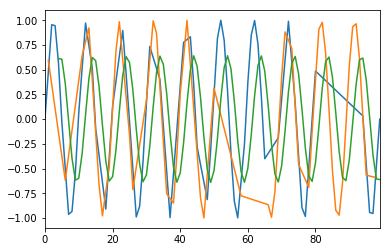

In [35]:
# 3
vals = np.array([0, 1])
needed = 100
stop = 20 * np.pi
chosen = np.random.choice(vals, needed)
df = pd.DataFrame({'flag': chosen, 'val': np.sin(np.linspace(start=0, stop=stop, num=needed))})

window_size = 5
grouped = df.groupby('flag')
grouped.val.plot()

df.val.rolling(window=window_size).mean().plot()

## Other Pandas Features

Pandas has a __TON__ of features and small implementation details that are there to make your life simpler. Features like `IntervalIndex` to index the data between two numbers instead of having a single label, for example, are very nice and ergonomic if you need them. Sparse DataFrames are also included, as well as many other computational tools, serialization capabilities, and more. If you need it - there's a good chance it already exists as a method in the pandas jungle.

## Data Visualization

As mentioned previously the visualization landscape in Python is rich, and is becoming richer by the day. Below we'll explore some of the options we have when put to the task to visualize data - 2D, 3D, nD, etD.

I'll assume that data, up to 2D, still resides in a DataFrame.

### `matplotlib`

The built-in `df.plot()` method is a simple wrapper around `pyplot` from `matplotlib`, and as we've seen before it works quite well for many types of plots, as long as we wish to keep them all overlayed in some sort. Let's look at examples taken straight from the [visualization](https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html) manual of pandas:

In [159]:
df = pd.DataFrame(np.random.randn(1000, 4),
                  index=ts.index, columns=list('ABCD'))
df = df.cumsum()
df

A          B          C          D
2000-01-01 -0.375842  -1.445057   0.196000   0.438798
2000-01-02 -0.413667  -0.984121   0.900317   0.098537
2000-01-03 -0.602314  -1.647125   1.585645   1.074348
2000-01-04 -0.676316  -4.399071   3.921438   0.597144
2000-01-05  0.626627  -2.898313   2.773654  -0.623521
...              ...        ...        ...        ...
2002-09-22 -3.976141 -39.168574 -19.717008 -26.329475
2002-09-23 -2.889540 -38.934647 -19.944804 -25.841951
2002-09-24 -2.276480 -39.485723 -19.219361 -25.808975
2002-09-25 -2.518862 -38.414244 -20.277520 -26.948219
2002-09-26 -2.982192 -39.436426 -20.867689 -26.232091

[1000 rows x 4 columns]

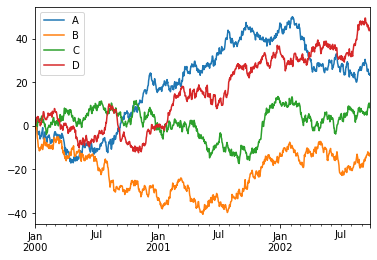

In [9]:
df.plot()

Nice to see we got a few things for "free", like sane x-axis labels and the legend.

We can tell pandas which column corresponds to x, and which to y:

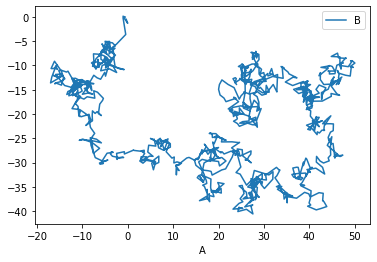

In [10]:
df.plot(x='A', y='B')

There are, of course, many possible types of plots that can be directly called from the pandas interface:

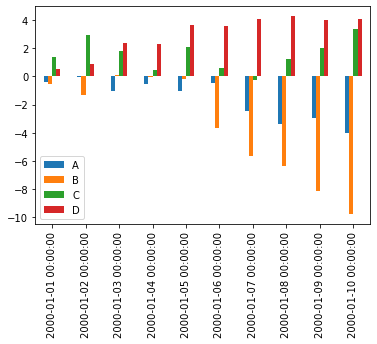

In [13]:
df.iloc[:10, :].plot.bar()

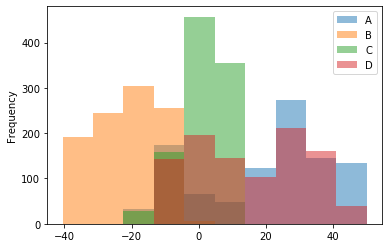

In [14]:
df.plot.hist(alpha=0.5)

Histogramming each column separately can be done by calling the `hist()` method directly:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe60f01dac8>,
      dtype=object)

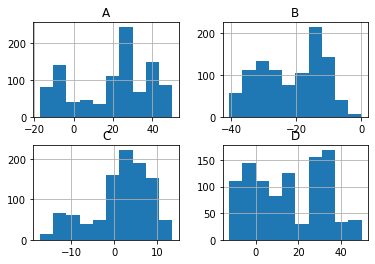

In [15]:
df.hist()

Lastly - one of my favorites:

In [161]:
df.plot.hexbin(x='A', y='B', gridsize=25)

ValueError: hexbin is not a valid plot kind

### Altair

Matplotlib (and pandas' interface to it) is the gold standard in the Python ecosystem - but there are other ecosystems as well. For example, [`vega-lite`](https://github.com/vega/vega-lite) is a famous plotting library for the web and Javascript, and it uses a different grammar to define its plots. If you're familiar with it you'll be delighted to hear that Python's [`altair`](https://altair-viz.github.io/) provides bindings to it, and even if you've never heard of it it's always nice to see that there are many other different ways to tell a computer how to draw stuff on the screen. Let's look at a couple of examples:

In [162]:
import altair as alt
alt.Chart(df).mark_point().encode(
    x='A',
    y='B',
)

alt.Chart(...)

In Altair you first create a chart object (a simple `Chart` above), and then you ask it to `mark_point()`, or `mark_line()`, to add that type of visualization to the chart. Then we specify the axis and other types of parameters (like color) and map (or `encode`) them to their corresponding column.

Let's see how Altair works with other datatypes:

In [27]:
datetime_df = pd.DataFrame({'value': np.random.randn(100).cumsum()},
                           index=pd.date_range('2020', freq='D', periods=100))

datetime_df.head()

value
2020-01-01 -0.005773
2020-01-02 -0.629849
2020-01-03 -0.452653
2020-01-04  0.494910
2020-01-05  0.510215

In [28]:
alt.Chart(datetime_df.reset_index()).mark_line().encode(
    x='index:T',
    y='value:Q',
)

alt.Chart(...)

Above we plot the datetime data by telling Altair that the column named "index" is of type `T`, i.e. Time, while the column "value" is of type `Q` for qunatitative. This notifies Altair of the type of data its plotting.

Lastly, let's see some interactive action:

In [163]:
from vega_datasets import data  # ready-made DFs for easy visualization examples

In [164]:
cars = data.cars
cars()

Name  Miles_per_Gallon  Cylinders  Displacement  \
0    chevrolet chevelle malibu              18.0          8         307.0   
1            buick skylark 320              15.0          8         350.0   
2           plymouth satellite              18.0          8         318.0   
3                amc rebel sst              16.0          8         304.0   
4                  ford torino              17.0          8         302.0   
..                         ...               ...        ...           ...   
401            ford mustang gl              27.0          4         140.0   
402                  vw pickup              44.0          4          97.0   
403              dodge rampage              32.0          4         135.0   
404                ford ranger              28.0          4         120.0   
405                 chevy s-10              31.0          4         119.0   

     Horsepower  Weight_in_lbs  Acceleration       Year  Origin  
0         130.0           3504          12.0 1970-01-01     USA  
1         165.0           3693          11.5 1970-01-01     USA  
2         150.0           3436          11.0 1970-01-01     USA  
3         150.0           3433          12.0 1970-01-01     USA  
4         140.0           3449          10.5 1970-01-01     USA  
..          ...            ...           ...        ...     ...  
401        86.0           2790          15.6 1982-01-01     USA  
402        52.0           2130          24.6 1982-01-01  Europe  
403        84.0           2295          11.6 1982-01-01     USA  
404        79.0           2625          18.6 1982-01-01     USA  
405        82.0           2720          19.4 1982-01-01     USA  

[406 rows x 9 columns]

In [165]:
cars_url = data.cars.url
cars_url  # The data is online and in json format which is standard practice for altair-based workflows

'https://vega.github.io/vega-datasets/data/cars.json'

In [166]:
alt.Chart(cars_url).mark_point().encode(
    x='Miles_per_Gallon:Q',
    y='Horsepower:Q',
    color='Origin:N',  # N for nominal, i.e. discrete and unordered (just like colors)
)

alt.Chart(...)

In [39]:
brush = alt.selection_interval()  # selection of type 'interval'

In [40]:
alt.Chart(cars_url).mark_point().encode(
    x='Miles_per_Gallon:Q',
    y='Horsepower:Q',
    color='Origin:N',  # N for nominal, i.e.discrete and unordered (just like colors)
).add_selection(brush)

alt.Chart(...)

The selection looks good but doesn't do anything. Let's add functionality:

In [42]:
alt.Chart(cars_url).mark_point().encode(
    x='Miles_per_Gallon:Q',
    y='Horsepower:Q',
    color=alt.condition(brush, 'Origin:N', alt.value('lightgray'))
).add_selection(
    brush
)

alt.Chart(...)

Altair has a ton more visualization types, some of which are more easily generated than others, and some are easier to generate using Altair rather than Matplotlib.

### Bokeh, Holoviews and pandas-bokeh

Bokeh is another visualization effort in the Python ecosystem, but this time it revolves around web-based plots. Bokeh can be used directly, but it also serves as a backend plotting device for more advanced plotting libraries, like Holoviews and pandas-bokeh. It's also designed in mind with huge datasets that don't fit in memory, which is something that other tools might have trouble visualizing.

In [167]:
import bokeh
import bokeh.io
from bokeh.plotting import figure as bkfig
bokeh.io.output_notebook()

Loading BokehJS ...

In [168]:
plot_obj = bkfig(plot_width=400, plot_height=400)
plot_obj.circle([1, 2, 3, 4, 5], [6, 7, 2, 4, 5], size=15, line_color="navy", fill_color="orange", fill_alpha=0.5)

bokeh.io.show(plot_obj)

We see how bokeh immediately outputs an interactive graph - by default it's also an HTML document that will open in your browser, but a couple of cells above we told bokeh to ouput its plots to the notebook instead. Bokeh can be used for many other types of plots, like:

In [169]:
datetime_df = datetime_df.reset_index()
datetime_df

level_0      index     value
0         0 2020-01-01 -0.005773
1         1 2020-01-02 -0.629849
2         2 2020-01-03 -0.452653
3         3 2020-01-04  0.494910
4         4 2020-01-05  0.510215
..      ...        ...       ...
95       95 2020-04-05 -0.379897
96       96 2020-04-06 -1.410775
97       97 2020-04-07 -0.878907
98       98 2020-04-08 -0.687141
99       99 2020-04-09 -3.239918

[100 rows x 3 columns]

In [170]:
plot_obj2 = bkfig(x_axis_type="datetime", title="Value as of this year", plot_height=350, plot_width=800)

plot_obj2.xgrid.grid_line_color=None
plot_obj2.ygrid.grid_line_alpha=0.5
plot_obj2.xaxis.axis_label = 'Time'
plot_obj2.yaxis.axis_label = 'Value'

plot_obj2.line(datetime_df.index, datetime_df.value)
bokeh.io.show(plot_obj2)

This is cool but not yet exciting. Adding a layer on top of bokeh is what makes it special. Let's look at [Pandas-Bokeh](https://github.com/PatrikHlobil/Pandas-Bokeh) first, which adds a `plot_bokeh()` method to dataframes once you import it:

In [171]:
df.plot_bokeh()

Figure(id='7267', ...)

In [54]:
import pandas_bokeh

In [55]:
df.plot_bokeh()

Figure(id='1400', ...)

This small library has many other types of plots, all based around Bokeh's feature set. Let's look at [energy consumption, split by source](https://www.bp.com/en/global/corporate/energy-economics/statistical-review-of-world-energy.html) (from the Pandas-Bokeh manual):

In [82]:
df_energy = pd.read_csv(r"https://raw.githubusercontent.com/PatrikHlobil/Pandas-Bokeh/master/docs/Testdata/energy/energy.csv", 
parse_dates=["Year"])
df_energy.head()

Year     Oil     Gas    Coal  Nuclear Energy  Hydroelectricity  \
0 1970-01-01  2291.5   826.7  1467.3            17.7             265.8   
1 1971-01-01  2427.7   884.8  1459.2            24.9             276.4   
2 1972-01-01  2613.9   933.7  1475.7            34.1             288.9   
3 1973-01-01  2818.1   978.0  1519.6            45.9             292.5   
4 1974-01-01  2777.3  1001.9  1520.9            59.6             321.1   

   Other Renewable  
0              5.8  
1              6.3  
2              6.8  
3              7.3  
4              7.7

In [58]:
df_energy.plot_bokeh.area(
    x="Year",
    stacked=True,
    colormap=["brown", "orange", "black", "grey", "blue", "green"],
    title="Worldwide energy consumption split by energy source",
    ylabel="Million tonnes oil equivalent",
    ylim=(0, 16000)
)

Figure(id='2289', ...)

Another Bokeh-based library is Holoviews. Its uniqueness stems from the way it handles DataFrames with multiple columns, and the way you add plots to each other. It's very suitable for Jupyter notebook based plots:

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
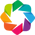

In [64]:
import holoviews as hv
hv.extension('bokeh')

In [61]:
df_energy.head()

Year     Oil     Gas    Coal  Nuclear Energy  Hydroelectricity  \
0 1970-01-01  2291.5   826.7  1467.3            17.7             265.8   
1 1971-01-01  2427.7   884.8  1459.2            24.9             276.4   
2 1972-01-01  2613.9   933.7  1475.7            34.1             288.9   
3 1973-01-01  2818.1   978.0  1519.6            45.9             292.5   
4 1974-01-01  2777.3  1001.9  1520.9            59.6             321.1   

   Other Renewable  
0              5.8  
1              6.3  
2              6.8  
3              7.3  
4              7.7

In [65]:
scatter = hv.Scatter(df_energy, 'Oil', 'Gas')
scatter

:Scatter   [Oil]   (Gas)

In [173]:
scatter + hv.Curve(df_energy, 'Oil', 'Hydroelectricity')

:Layout
   .Scatter.I :Scatter   [Oil]   (Gas)
   .Curve.I   :Curve   [Oil]   (Hydroelectricity)

In [90]:
hv.HoloMap({y: hv.Bars(df_energy.loc[df_energy["Year"] == y, "Coal"]) for y in df_energy["Year"]}, kdims=['Year'])

:HoloMap   [Year]
   :Bars   [index]   (Coal)

Holoviews really needs an entire class (or two) to go over its concepts, but once you get them you can create complicated visualizations which include a strong interactive component in a few lines of code.

### Seaborn

A library which has really become a shining example of quick, efficient and clear plotting in the post-pandas era is Seaborn. It combines many of the features of the previous libraries into a very concise API. Unlike a few of the previous libraries, however, it doesn't use Bokeh as its backend, but Matplotlib, which means that the interactivity of the resulting plots isn't as good. Be that as it may - it's still a widely used library, and for good reasons.

In order to use seaborn to its full extent (and really all of the above libraries) we have to take a short detour and understand how to transform our data into a **long-form format.**

#### Long form ("tidy") data

Tidy data was first defined the R language (its "tidyverse" subset) as the preferred format for analysis and visualization. If you assume that the data you're about to visualize is always in such a format, you can design plotting libraries that use these assumptions to cut the number of lines of code you have to write in order to see the final art. Tidy data migrated to the Pythonic data science ecosystem, and nowadays it's the preferred data format in the pandas ecosystem as well. The way to construct a "tidy" table is to follow three simple rules:
1. Each variable forms a column.
2. Each observation forms a row.
3. Each type of observational unit forms a table.

In the paper [defining tidy data](http://vita.had.co.nz/papers/tidy-data.pdf), the following example is given: Assume we have the following data table:

| name | treatment a | treatment b |
|------|--------------|-------|
| John Smith | - | 20.1 |
| Jane Doe | 15.1 | 13.2 |
| Mary Johnson | 22.8 | 27.5 |

Is this the "tidy" form? What are the variables and observations here? Well, we could've written this table in a different ('transposed') format:

|treatment type| John Smith | Jane Doe | Mary Johnson |
| -------------| -----------| -------- | ------------ |
| treat. a | - | 15.1 | 22.8 |
| treat. b | 20.1 | 13.2 | 27.5 |

Is this "long form"?

In both cases, the answer is no. We have to move each observation into its own row, and in the above two tables two (or more) observations were placed in the same row. For example, Both observations concerning Mary Johnson (the measured value of treatment a and b) were located in the same row, which violates rule #2 of the "tidy" data rules. This is how the tidy version of the above tables look like:

| name | treatment | measurement |
| ---- | --------- | ----------- |
| John Doe | a | - |
| Jane Doe | a | 15.1 |
| Mary Johnson | a | 22.8 |
| John Doe | b | 20.1 |
| Jane Doe | b | 13.2 |
| Mary Johnson | b | 27.5 |

Now each measurement has a single row, and the treatment column became an "index" of some sort. The only shortcoming of this approach is the fact that we now have more cells in the table - we had 9 in the previous two versions, but this one has 18. This is quite a jump, but if we're smart about our data types (categorical data types) then the jump in memory usage wouldn't become too hard.

As I wrote in the previous class, pandas has methods to transform data into its long form. You'll usually need to use `df.stack()` or `df.melt()` to make it tidy. Let's try to make our own data tidy:

In [114]:
df = pd.read_csv('extra_material/pew_raw.csv')
df

religion   10000   20000  30000  40000  50000  75000
0                  Agnostic      27      34     60     81     76    137
1                   Atheist      12      27     37     52     35     70
2                  Buddhist      27      21     30     34     33     58
3                  Catholic     418     617    732    670    638   1116
4         Dont know/refused      15      14     15     11     10     35
5         Evangelical Prot      575     869   1064    982    881   1486
6                    Hindu        1       9      7      9     11     34
7  Historically Black Prot      228     244    236    238    197    223
8         Jehovahs Witness       20      27     24     24     21     30
9                   Jewish       19      19     25     25     30     95

This is a table from the Pew Research Center on the relations between income (in USD) and religion. This dataset is not in a tidy format since the column headers contain information about specific observations (measurements). For example, the 27 agnostic individuals who donated less than \\$10k represent a measurement, and the 34 that donated \$10k-20k represent another one, and so on. 

To make it tidy we'll use `melt()`:

In [115]:
tidy_df = (pd.melt(df,
                  ["religion"],
                  var_name="income",
                  value_name="freq")
           .sort_values(by=["religion"])
           .reset_index(drop=True)
           .astype({'income': 'category', 'religion': 'category'}))

In [116]:
tidy_df

religion  income  freq
0                   Agnostic   10000    27
1                   Agnostic   40000    81
2                   Agnostic   50000    76
3                   Agnostic   75000   137
4                   Agnostic   20000    34
5                   Agnostic   30000    60
6                    Atheist   50000    35
7                    Atheist   30000    37
8                    Atheist   20000    27
9                    Atheist   40000    52
10                   Atheist   10000    12
11                   Atheist   75000    70
12                  Buddhist   50000    33
13                  Buddhist   10000    27
14                  Buddhist   20000    21
15                  Buddhist   40000    34
16                  Buddhist   75000    58
17                  Buddhist   30000    30
18                  Catholic   50000   638
19                  Catholic   40000   670
20                  Catholic   30000   732
21                  Catholic   75000  1116
22                  Catholic   20000   617
23                  Catholic   10000   418
24         Dont know/refused   30000    15
25         Dont know/refused   50000    10
26         Dont know/refused   10000    15
27         Dont know/refused   75000    35
28         Dont know/refused   20000    14
29         Dont know/refused   40000    11
30         Evangelical Prot    30000  1064
31         Evangelical Prot    75000  1486
32         Evangelical Prot    20000   869
33         Evangelical Prot    10000   575
34         Evangelical Prot    50000   881
35         Evangelical Prot    40000   982
36                    Hindu    75000    34
37                    Hindu    30000     7
38                    Hindu    50000    11
39                    Hindu    20000     9
40                    Hindu    40000     9
41                    Hindu    10000     1
42  Historically Black Prot    50000   197
43  Historically Black Prot    40000   238
44  Historically Black Prot    75000   223
45  Historically Black Prot    30000   236
46  Historically Black Prot    20000   244
47  Historically Black Prot    10000   228
48         Jehovahs Witness    10000    20
49         Jehovahs Witness    40000    24
50         Jehovahs Witness    75000    30
51         Jehovahs Witness    50000    21
52         Jehovahs Witness    30000    24
53         Jehovahs Witness    20000    27
54                   Jewish    30000    25
55                   Jewish    40000    25
56                   Jewish    20000    19
57                   Jewish    10000    19
58                   Jewish    50000    30
59                   Jewish    75000    95

The first argument to melt is the column name that will be used as the "identifier variable", i.e. will be repeated as necessary to be used as an "index" of some sorts. `var_name` is the new name of the column we made from the values in the old columns, and `value_name` is the name of the column that contains the actual values in the cells from before.

After the melting I sorted the DF to make it look prettier (all agnostics in row, etc.) and threw away the old and irrelevant index. Finally I converted the "religion" and "income" columns to a categorical data type, which saves memory and better conveys their true meaning.

Now, once we have this long form data, we can put seaborn to the test.

In [129]:
import seaborn as sns

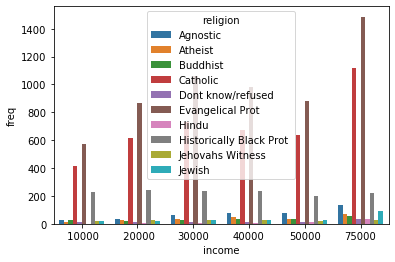

In [130]:
sns.barplot(data=tidy_df, x='income', y='freq', hue='religion')

Each seaborn [visualization functions](https://seaborn.pydata.org/api.html) has a "data" keyword to which you pass your DataFrame, and then a few other with which you specify the relations of the columns to one another. Look how simple it was to receive this beautiful bar chart.

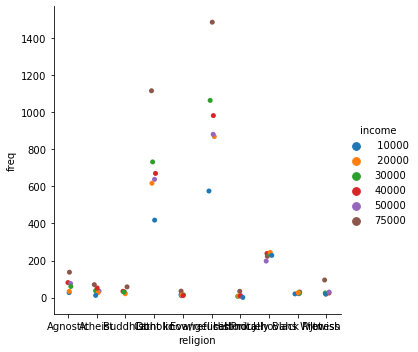

In [133]:
sns.catplot(data=tidy_df, x="religion", y="freq", hue="income")

Seaborn also takes care of faceting the data for us:

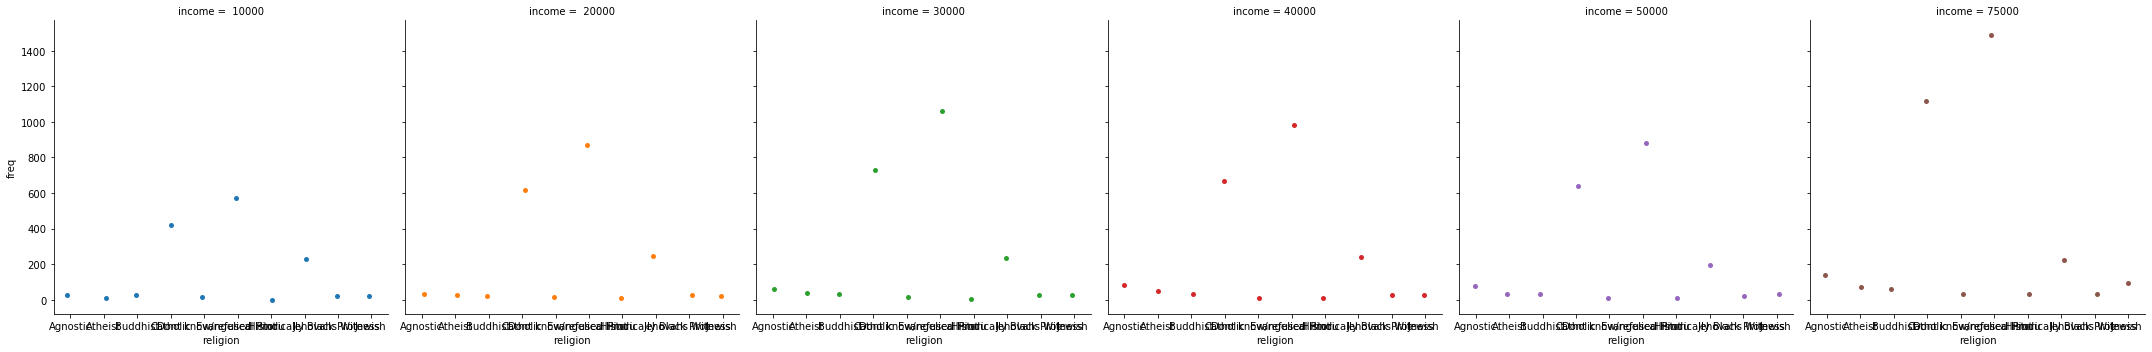

In [134]:
sns.catplot(data=tidy_df, x="religion", y="freq", hue="income", col="income")

Figure is a bit small? We can use matplotlib to change it:

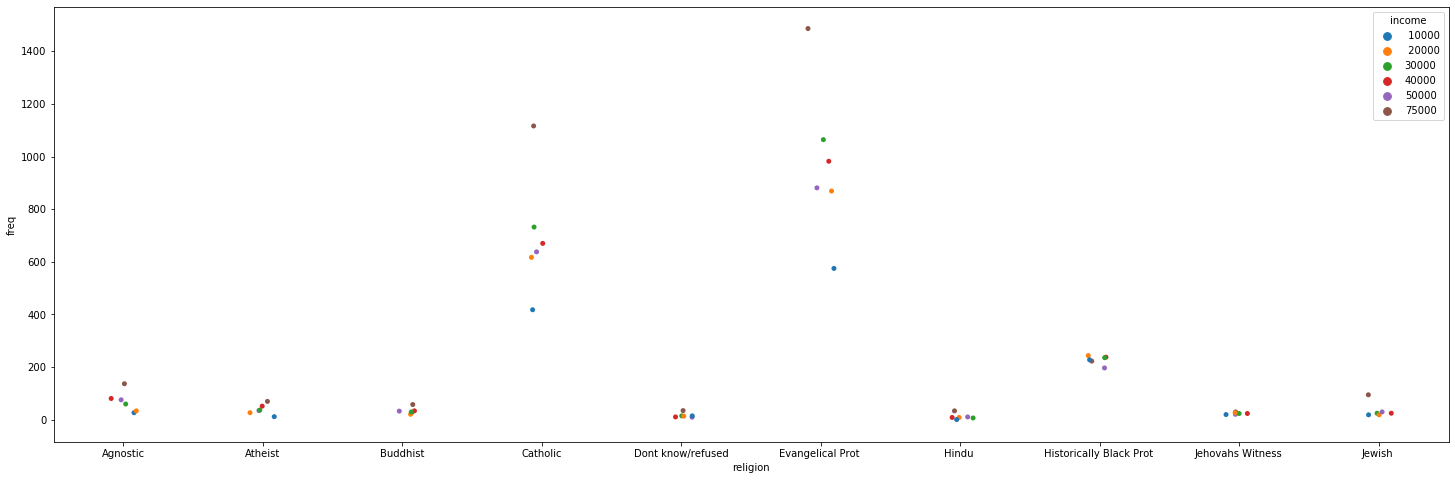

In [138]:
_, ax = plt.subplots(figsize=(25, 8))
sns.stripplot(data=tidy_df, x="religion", y="freq", hue="income", ax=ax)

Simpler data can also be visualized - no need for categorical variables:

In [148]:
simple_df = pd.DataFrame(np.random.random((1000, 4)), columns=list('abcd'))
simple_df

a         b         c         d
0    0.404110  0.771049  0.522079  0.532473
1    0.985421  0.909163  0.386604  0.393773
2    0.078195  0.981137  0.633819  0.036770
3    0.289243  0.031160  0.521845  0.267856
4    0.911391  0.192010  0.000117  0.983284
..        ...       ...       ...       ...
995  0.842092  0.930198  0.079753  0.361053
996  0.985235  0.440500  0.279077  0.967960
997  0.082886  0.158316  0.038227  0.560163
998  0.146263  0.870956  0.838675  0.293800
999  0.425178  0.523695  0.638714  0.265884

[1000 rows x 4 columns]

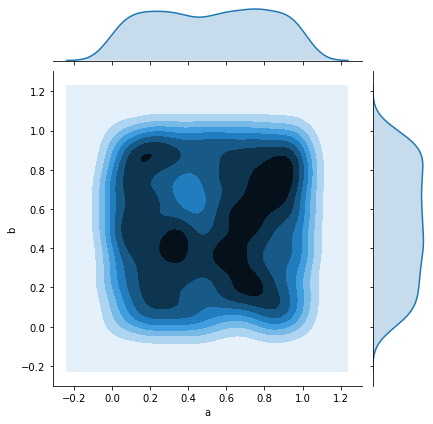

In [146]:
sns.jointplot(data=simple_df, x='a', y='b', kind='kde')

And complex relations can also be visualized:

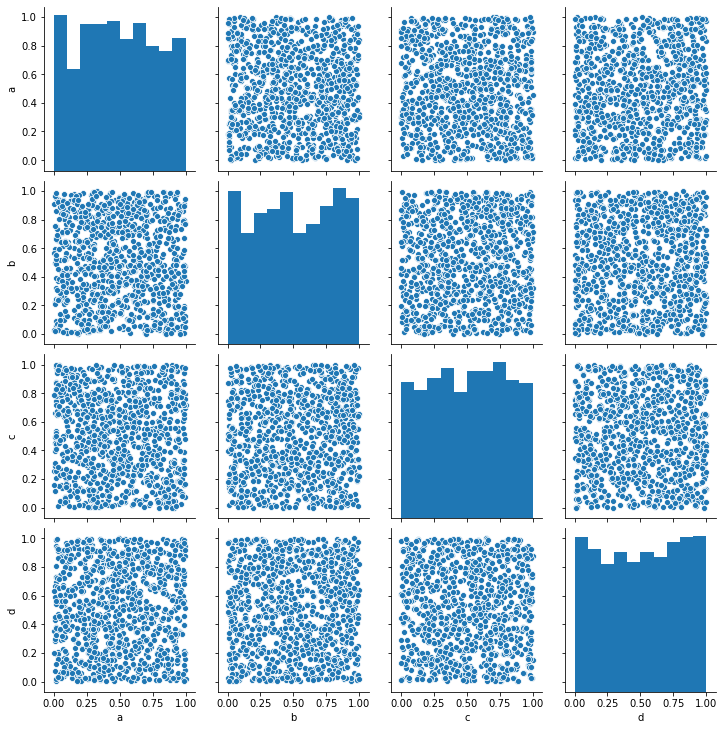

In [149]:
sns.pairplot(data=simple_df)

Seaborn should probably be your go-to choice when all you need is a 2D graph.

### napari

For plots for multidimensional data, [`napari`](https://napari.org/) is the way to go:

In [174]:
# 2D works great, and is also highly interactive

%gui qt

from skimage import data
import napari
viewer = napari.view_image(data.astronaut(), rgb=True)

In [181]:
# 3D is awesome as well
%gui qt
blobs = data.binary_blobs(length=64, volume_fraction=0.1, n_dim=3).astype(
    float
)
viewer = napari.Viewer(ndisplay=3)
# add the volume
viewer.add_image(blobs, scale=[3, 1, 1])

<Image layer 'blobs' at 0x7fe5e8ca1b00>

# Higher Dimensionality - `xarray`

Pandas is amazing, but has its limits. A `DataFrame` can be a multi-dimensional container when using a `MultiIndex`, but it's limited to a subset of uses in which another layer of indexing makes sense.

In many occasions, however, our data is truly high-dimensional. A simple case could be electrophysiological recordings, or calcium traces. In these cases we have several indices (some can be categorical), like "Sex", "AnimalID", "Date", "TypeOfExperiment" and perhaps a few more. But the data itself is a vector of numbers representing voltage or fluorescence. Having this data in a DataFrame seems a bit "off" - what are the columns on this DF? Is each column a voltage measurement? Or if each column is a measurement, how do you deal with the indices? We can use nested columns (`MultiIndex` the columns), but it's not a very modular approach.

This is a classic example where pandas DF "fail", and indeed pandas used to have a higher-dimensionality container named `Panel`. However, in late 2016 pandas devs deprecated it, publicly announcing that they intend to drop support for `Panel`s sometime in the future, and whoever needs a higher-dimensionality container should use `xarray`.

`xarray` is a labeled n-dimensional array. Just like a DataFrame is a labeled 2D array, i.e. with names to its axes rather than numbers, in `xarray` each dimension has a name (`time`, `temp`, `voltage`) and its indices ("coordinates") can also have labels (like a timestamp, for example). In addition, each `xarray` object also has metadata attached to it, in which we can write details that do not fit a columnar structure (experimenter name, hardware and software used for acquisition, etc.).

## DataArray

In [40]:
import numpy as np
import xarray as xr


da = xr.DataArray(np.random.random((10, 2)))
da

<xarray.DataArray (dim_0: 10, dim_1: 2)>
array([[0.177208, 0.611385],
       [0.412153, 0.500557],
       [0.978263, 0.9627  ],
       [0.121471, 0.446623],
       [0.576593, 0.375859],
       [0.533611, 0.69296 ],
       [0.024204, 0.245829],
       [0.309452, 0.495504],
       [0.554501, 0.538553],
       [0.064099, 0.951278]])
Dimensions without coordinates: dim_0, dim_1

The basic building block of `xarray` is a DataArray, an n-dimensional counter part of a pandas' Series. It has two dimensions, just like the numpy array that its based upon. We didn't specify names for these dimensions, so currently they're called `dim_0` and `dim_1`. We also didn't specify coordinates (indices), so the printout doesn't report of any coordinates for the data.

In [41]:
da.values  # just like pandas

array([[0.17720786, 0.61138474],
       [0.41215266, 0.50055748],
       [0.97826321, 0.96270021],
       [0.12147099, 0.44662291],
       [0.57659303, 0.37585922],
       [0.53361088, 0.69296042],
       [0.02420421, 0.2458294 ],
       [0.3094522 , 0.49550449],
       [0.55450064, 0.53855254],
       [0.06409927, 0.95127846]])

In [42]:
da.coords

Coordinates:
    *empty*

In [43]:
da.dims

('dim_0', 'dim_1')

In [44]:
da.attrs

OrderedDict()

We'll add coordinates and dimension names and see how indexing works:

In [45]:
dims = ('time', 'repetition')
coords = {'time': np.linspace(0, 1, num=10),
          'repetition': np.arange(2)}
da2 = xr.DataArray(np.random.random((10, 2)), dims=dims, coords=coords)
da2

<xarray.DataArray (time: 10, repetition: 2)>
array([[0.222711, 0.858208],
       [0.606041, 0.290344],
       [0.366621, 0.910726],
       [0.797924, 0.505932],
       [0.29368 , 0.698112],
       [0.528895, 0.319191],
       [0.18192 , 0.819311],
       [0.219912, 0.185813],
       [0.914255, 0.485104],
       [0.912049, 0.267344]])
Coordinates:
  * time        (time) float64 0.0 0.1111 0.2222 0.3333 ... 0.7778 0.8889 1.0
  * repetition  (repetition) int64 0 1

In [49]:
da2.loc[0.1:0.3, 1]  # rows 1-2 in the second column

<xarray.DataArray (time: 2)>
array([0.290344, 0.910726])
Coordinates:
  * time        (time) float64 0.1111 0.2222
    repetition  int64 1

In [50]:
da2.isel(time=slice(3, 7))  # dimension name and integer label (sel = select)

<xarray.DataArray (time: 4, repetition: 2)>
array([[0.797924, 0.505932],
       [0.29368 , 0.698112],
       [0.528895, 0.319191],
       [0.18192 , 0.819311]])
Coordinates:
  * time        (time) float64 0.3333 0.4444 0.5556 0.6667
  * repetition  (repetition) int64 0 1

In [59]:
da2.sel(time=slice(0.1, 0.3), repetition=[1])  # dimension name and coordinate label

<xarray.DataArray (time: 2, repetition: 1)>
array([[0.290344],
       [0.910726]])
Coordinates:
  * time        (time) float64 0.1111 0.2222
  * repetition  (repetition) int64 1

Other operations on DataArrays, such as computations, grouping and such, are done very similarly to DataFrames and numpy arrays.

## Dataset

A Dataset is to a DataArray what a DataFrame is to a Series. In other words, it's a collection of DataArrays that share coordinates.

In [52]:
da2  # a reminder. We notice that this could've been a DataFrame as well

<xarray.DataArray (time: 10, repetition: 2)>
array([[0.222711, 0.858208],
       [0.606041, 0.290344],
       [0.366621, 0.910726],
       [0.797924, 0.505932],
       [0.29368 , 0.698112],
       [0.528895, 0.319191],
       [0.18192 , 0.819311],
       [0.219912, 0.185813],
       [0.914255, 0.485104],
       [0.912049, 0.267344]])
Coordinates:
  * time        (time) float64 0.0 0.1111 0.2222 0.3333 ... 0.7778 0.8889 1.0
  * repetition  (repetition) int64 0 1

In [53]:
ds = xr.Dataset({'ephys': da2,
                 'calcium': ('time', np.random.random(10))},
                attrs={'AnimalD': 701,
                       'ExperimentType': 'double',
                       'Sex': 'Male'})
ds

<xarray.Dataset>
Dimensions:     (repetition: 2, time: 10)
Coordinates:
  * time        (time) float64 0.0 0.1111 0.2222 0.3333 ... 0.7778 0.8889 1.0
  * repetition  (repetition) int64 0 1
Data variables:
    ephys       (time, repetition) float64 0.2227 0.8582 0.606 ... 0.912 0.2673
    calcium     (time) float64 0.7009 0.8002 0.1631 ... 0.5411 0.1411 0.9711
Attributes:
    AnimalD:         701
    ExperimentType:  double
    Sex:             Male

In [54]:
ds['ephys']  # individual DataArrays can be dissimilar in shape

<xarray.DataArray 'ephys' (time: 10, repetition: 2)>
array([[0.222711, 0.858208],
       [0.606041, 0.290344],
       [0.366621, 0.910726],
       [0.797924, 0.505932],
       [0.29368 , 0.698112],
       [0.528895, 0.319191],
       [0.18192 , 0.819311],
       [0.219912, 0.185813],
       [0.914255, 0.485104],
       [0.912049, 0.267344]])
Coordinates:
  * time        (time) float64 0.0 0.1111 0.2222 0.3333 ... 0.7778 0.8889 1.0
  * repetition  (repetition) int64 0 1

## Exercise - Rat Visual Stimulus Experiment Database

You're measuring the potential of neurons in a rat's brain over time in response to flashes of light
using a multi-electrode array surgically inserted into the rat's skull. Each trial is two seconds
long, and one second into the trial a short, 100 ms, bright light is flashed at the animal. After 30 seconds
the experiment is replicated, for a total of 4 repetitions. The relevant parameters are the following:

- Rat ID.
- Experimenter name.
- Rat gender.
- Measured voltage (10 electrode, 10k samples representing two seconds).
- Stimulus index (mark differently the pre-, during- and post-stimulus time).
- Repetition number.

Mock data and model it, you can add more parameters if you feel so.

Experimental timeline:
```
       1s          100ms             0.9s             30s
Start -----> Flash -----> End flash -----> End trial -----> New trial
|                                                                    |
|--------------------------------------------------------------------|
                                   x4
```

### Methods and functions to implement

1. There should be a class holding this data table, `VisualStimData`, alongside
several methods for the analysis of the data. The class should have a `data`
attribute containing the data table, in a `xarray.DataArray` or a `xarray.Dataset`.

2. Write a function (not a method) that returns an instance of the class with mock data.
    ```python
    def mock_stim_data() -> VisualStimData:
        """ Creates a new VisualStimData instance with mock data """
    ```

    When simulating the recorded voltage, it's completely fine to not model spikes precisely,
    with leaky integration and so forth - randoming numbers and treating them as the recorded
    neural potential is fine. There are quite a few ways to model _real_ neurons,
    if so you wish, [brian](http://brian2.readthedocs.io/en/stable/index.html) being one
    of them. If your own research will benefit from knowing how to use these tools, this
    exercise is a great place to start familiarizing yourself with them.

3. Write a method that receives a repetition number, rat ID, and a list of electrode numbers,
and plots the voltage recorded from these electrodes. The single figure should be
divided into however many plots needed, depending on the length of the list of electrode
numbers.

    ```python
    def plot_electrode(self, rep_number: int, rat_id: int, elec_number: tuple=(0,)):
        """
        Plots the voltage of the electrodes in "elec_number" for the rat "rat_id" in the repetition
        "rep_number". Shows a single figure with subplots.
        """
    ```

4. To see if the different experimenters influence the measurements, write a method that
calculates the mean, standard deviation and median of the average voltage trace across all
repetitions, for each experimenter, and shows a bar plot of it.

    ```python
    def experimenter_bias(self):
        """ Shows the statistics of the average recording across all experimenters """
    ```

### Exercise solutions below...

In [55]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


class VisualStimData:
    """
    Data and methods for the visual stimulus ePhys experiment.
    The data table itself is held in self.data, an `xarray` object.
    Inputs:
        data: xr.DataArray or xr.Dataset
    Methods:
         ...
    """
    def __init__(self, data: xr.Dataset, ):
        assert isinstance(data, xr.Dataset)
        self.data = data


    def plot_electrode(self, rep_number: int, rat_id: int, elec_number: tuple=(0,)):
        """
        Plots the voltage of the electrodes in "elec_number" for the rat "rat_id" in the repetition
        "rep_number". Shows a single figure with two subplots, for male and female rats.
        """
        fig, axes = plt.subplots(len(elec_number), 1)
        axes = np.array([axes]) if isinstance(axes, plt.Axes) else axes
        time = self.data['time']
        for ax, elec in zip(axes, elec_number):
            to_plot = self.data.sel(rep=rep_number, rat_id=rat_id, elec=elec)['volt'].values
            ax.plot(time, to_plot)
            ax.set_xlabel('Time [s]')
            ax.set_ylabel('Voltage [V]')
            ax.set_title(f'Electrode {elec}')

        fig.tight_layout()

    def experimenter_bias(self):
        """ Shows the statistics of the average recording across all experimenters """
        names = np.unique(self.data.coords['exp_name'].values)
        means = []
        stds = []
        medians = []
        for experimenter in names:
            data = self.data.sel(exp_name=experimenter)['volt'].values
            means.append(np.abs(data.mean()))
            stds.append(np.abs(data.std()))
            medians.append(np.abs(np.median(data)))

        # Plotting
        fig, ax = plt.subplots()
        x_locs = np.arange(len(names))
        width = 0.3
        rect0 = ax.bar(x_locs, means, width, color='C0')
        rect1 = ax.bar(x_locs + width, stds, width, color='C1')
        rect2 = ax.bar(x_locs - width, medians, width, color='C2')

        ax.set_xticks(x_locs)
        ax.set_xticklabels(names)
        ax.legend((rect0[0], rect1[0], rect2[0]), ('Mean', 'STD', 'Median'))
        ax.set_title('Experimenter Bias (absolute values)')
        ax.set_ylabel('Volts [V]')

In [56]:
def mock_stim_data() -> VisualStimData:
    """ Creates a new VisualStimData instance with mock data """
    num_of_animals = 20
    num_of_reps = 4
    reps = np.arange(num_of_reps, dtype=np.uint8)
    total_num_of_exp = num_of_animals * num_of_reps
    exp_number = np.arange(total_num_of_exp, dtype=np.uint32)
    
    rat_id_ints, rat_id = _generate_rat_data(num_of_animals)
    room_temp, room_humid = _generate_temp_hum_values(total_num_of_exp)
    experimenters = _generate_experimenter_names(num_of_animals, num_of_reps)
    rat_sex = _generate_rat_gender(num_of_animals, num_of_reps)
    stim, electrode_array, time, volt = _generate_voltage_stim(num_of_animals, num_of_reps)

    # Construct the Dataset - this could be done with a pd.MultiIndex as well
    ds = xr.Dataset({'temp': (['num'], room_temp),
                     'humid': (['num'], room_humid),
                     'volt': (['elec', 'time', 'rat_id', 'rep'], volt),
                     'stim': (['time'], stim)},
                    coords={'elec': electrode_array,
                            'time': time,
                            'rat_id': rat_id,
                            'rep': reps,
                            'exp_name': experimenters,
                            'sex': rat_sex,
                            'num': exp_number,
                            })

    ds.attrs['exp_date'] = pd.to_datetime('today')
    ds.attrs['rat_strain'] = 'Sprague Dawley'

    return VisualStimData(ds)
    
def _generate_rat_data(num_of_animals):
    rat_id_ints = np.random.choice(np.arange(100, 900), size=300, replace=False)
    rat_id = np.random.choice(rat_id_ints, size=num_of_animals, replace=False)
    return rat_id_ints, rat_id


def _generate_temp_hum_values(total_num_of_exp):
    room_temp = np.random.random(total_num_of_exp) * 3 + 23  # between 23 and 26 C
    room_humid = np.random.randint(30, 70, size=total_num_of_exp)
    return room_temp, room_humid

def _generate_experimenter_names(num_of_animals, num_of_reps):
    names = ['Dana', 'Motti', 'Sam', 'Daria']
    experimenters = np.random.choice(names, size=num_of_animals, replace=True)
    experimenters = np.tile(experimenters, num_of_reps)
    return experimenters

def _generate_rat_gender(num_of_animals, num_of_reps):
    sex = ['F', 'M']
    rat_sex = np.random.choice(sex, size=num_of_animals, replace=True)
    rat_sex = np.tile(rat_sex, num_of_reps)
    return rat_sex


def _generate_voltage_stim(num_of_animals, num_of_reps):
    pre_stim = 1  # seconds
    stim_time = 0.1  # seconds
    post_stim = 0.9  # seconds
    sampling_rate = 5000  # Hz
    freq = 1 / sampling_rate
    experiment_length = int(pre_stim + stim_time + post_stim)
    electrodes = 10
    samples = sampling_rate * experiment_length

    # Random voltage values from N(0.068, 0.0004)
    volt = 0.02 * np.random.randn(electrodes, samples, num_of_animals,
                                 num_of_reps).astype(np.float32) - 0.068  # in volts, not millivolts
    volt[volt > -0.02] = 0.04  # "spikes"
    time = pd.date_range(start=pd.to_datetime('today'), periods=experiment_length * sampling_rate,
                         freq=f'{freq}S')
    electrode_array = np.arange(electrodes, dtype=np.uint16)

    # Stim index - -1 is pre, 0 is stim, 1 is post
    stim = np.zeros(int(samples), dtype=np.int8)
    stim[:int(pre_stim*sampling_rate)] = -1
    stim[int((pre_stim + stim_time)*sampling_rate):] += 1
    return stim, electrode_array, time, volt

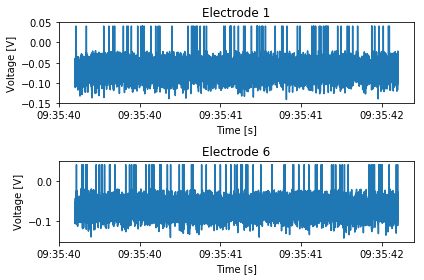

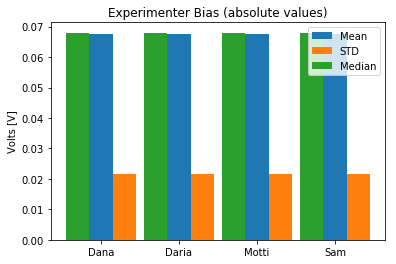

In [57]:
# Run the solution
stim_data = mock_stim_data()
ids = stim_data.data['rat_id']
arr = stim_data.plot_electrode(rep_number=2, rat_id=ids[0], elec_number=(1, 6))
stim_data.experimenter_bias()